# Import Libary

In [ ]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

import matplotlib.pyplot as plt

In [ ]:
# !pip install yfinance
# !pip install yahoofinancials

In [ ]:
import yfinance as yf
from yahoofinancials import YahooFinancials

In [ ]:
data_df = yf.download('TSTH.BK', 
                      start='2000-01-01', 
                      end='2022-01-01', 
                      progress=False,
)
data_df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-12-24,1.50,1.50,1.46,1.46,1.46,2588300
2021-12-27,1.46,1.48,1.45,1.46,1.46,4105700
2021-12-28,1.46,1.48,1.45,1.46,1.46,3954100
2021-12-29,1.45,1.47,1.44,1.46,1.46,5221700
2021-12-30,1.47,1.48,1.46,1.46,1.46,3296600


In [ ]:
data_df.shape

(4701, 6)

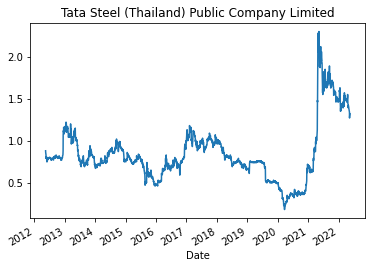

In [ ]:
ticker = yf.Ticker('TSTH.BK')
aapl_df = ticker.history(period="10y")
aapl_df['Close'].plot(title="Tata Steel (Thailand) Public Company Limited")

Text(0, 0.5, 'Close Price (Bath)')

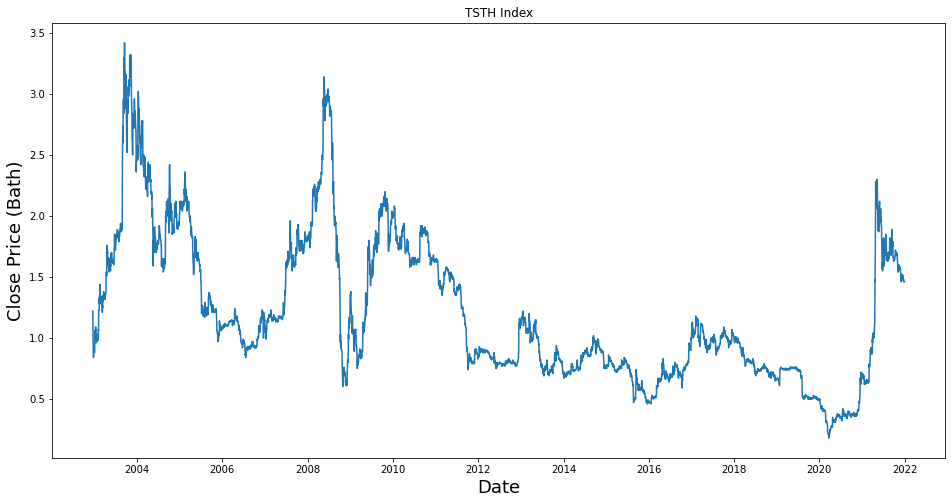

In [ ]:
plt.figure(figsize=(16,8))
plt.title('TSTH Index')
plt.plot(data_df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price (Bath)', fontsize=18)

In [ ]:
data_df.filter(['Close','Volume']).values

array([[1.22000003e+00, 1.36885600e+08],
       [1.03999996e+00, 1.08260300e+08],
       [1.01999998e+00, 9.63655000e+07],
       ...,
       [1.46000004e+00, 3.95410000e+06],
       [1.46000004e+00, 5.22170000e+06],
       [1.46000004e+00, 3.29660000e+06]])

In [ ]:
train_size = 70
test_size = 100 - train_size

In [ ]:
# ดึงเฉพาะราคาปิดมา
data = data_df.filter(['Close','Volume'])

#แปลงข้อมูลใน data ให้เป็น Numpy array
dataset = data.values

#แบ่งข้อมูลแบบ train 80, test 20
#ดูว่า train 80% มีขนาดเท่าไร
training_data_len = math.ceil(len(dataset) * train_size//100) # หาขนาดของ train
test_data_len = training_data_len - len(dataset)
print('size of sample data is {} of {}'.format(training_data_len, len(dataset)))

size of sample data is 3290 of 4701


In [ ]:
dataset[0:5]

array([[1.22000003e+00, 1.36885600e+08],
       [1.03999996e+00, 1.08260300e+08],
       [1.01999998e+00, 9.63655000e+07],
       [8.99999976e-01, 4.87095000e+07],
       [8.39999974e-01, 2.84229000e+07]])

# Standardization
ปรับเสกลของราคาปิดของหุ้นลงมา


In [ ]:
# ปรับ Scaling
# scaler = MinMaxScaler(feature_range=(0,1))
# scaled_data = scaler.fit_transform(dataset)

In [ ]:
data

,Close,Volume
Date,,
2002-12-18,1.22,136885600
2002-12-19,1.04,108260300
2002-12-20,1.02,96365500
2002-12-23,0.90,48709500
2002-12-24,0.84,28422900
...,...,...
2021-12-24,1.46,2588300
2021-12-27,1.46,4105700
2021-12-28,1.46,3954100


In [ ]:
normalized_df = data.copy()

In [ ]:
normalized_df['Close'] = (normalized_df['Close']-normalized_df['Close'].min())/(normalized_df['Close'].max()-normalized_df['Close'].min())
normalized_df['Volume'] = (normalized_df['Volume']-normalized_df['Volume'].min())/(normalized_df['Volume'].max()-normalized_df['Volume'].min())
# normalized_df

In [ ]:
data_norm = normalized_df.filter(['Close','Volume'])

In [ ]:
scaled_data = data_norm.values

In [ ]:
scaled_data[0:5]

array([[0.32098765, 0.12498642],
       [0.26543208, 0.09884946],
       [0.25925925, 0.08798865],
       [0.22222221, 0.04447528],
       [0.20370369, 0.02595216]])

In [ ]:
x = [[i] for i in range(20)]
x = np.array(x)
# x
# x = x.reshape(x[0],x[1],1)
# x
print(x[0:10, :])

[[0]
 [1]
 [2]
 [3]
 [4]
 [5]
 [6]
 [7]
 [8]
 [9]]


# Make Training Data

Create data for training

In [ ]:
training_lag = 60 # day
prediction_lag = 30

In [ ]:
# เลือก 80 % จาก scaled_data
train_data = scaled_data[0:training_data_len, :]

x_train = [] 
y_train = []

# เลือกข้อมูลมา x วัน(x_train) เพือทำนายวันถัดไป(y_train)              # 0-60 
# for i in range(training_lag, len(train_data)):                    # 1 - 61
for i in range( training_lag, (len(train_data) - prediction_lag + 1) ):                    
    x_train.append(train_data[i-training_lag:i, 0:1])               # 2 - 62 ... (len = 60 items)
    y_train.append(train_data[i : i + prediction_lag, 0])                            # same data but it's labels for evaluate the model
    # print(x_train,'---', y_train)
    # if i <= 61:
      # print(x_train)
      # print(y_train)
      # print()
    
#จากนั้นแปลงกับให้เป็น Numpy array
x_train, y_train = np.array(x_train), np.array(y_train)

In [ ]:
# x_train

In [ ]:
x_train.shape, y_train.shape

((3201, 60, 1), (3201, 30))

In [ ]:
# reshape
x_train = np.reshape( x_train, (x_train.shape[0], x_train.shape[1], 1) )

In [ ]:
x_train.shape

(3201, 60, 1)

In [ ]:
# x_train

In [ ]:
(x_train.shape[1],1) # --> tuple // for each learn 1 data point

(60, 1)

In [ ]:
scaled_data

array([[0.32098765, 0.12498642],
       [0.26543208, 0.09884946],
       [0.25925925, 0.08798865],
       ...,
       [0.39506173, 0.00361038],
       [0.39506173, 0.00476779],
       [0.39506173, 0.00301003]])

In [ ]:
# dataset[training_data_len:, 0]

# Make Testing Data

In [ ]:
training_data_len, dataset.shape

(3290, (4701, 2))

In [ ]:
scaled_data[training_data_len - training_lag: , :].shape

(1471, 2)

In [ ]:
abs(test_data_len)

1411

In [ ]:
# ดึง test data 20% ออกมา
test_data = scaled_data[training_data_len : , :] 
# train_data = scaled_data[0:training_data_len, :]

x_test = [] 
y_test = []
# y_test = dataset[training_data_len:, 0] # get only labels

# for i in range(training_lag, len(test_data)): #(60, 792)
for i in range( training_lag, (len(test_data) - prediction_lag + 1) ):  
    x_test.append(test_data[i - training_lag :i, 0:1]) # keep price for use to be labels
    y_test.append(test_data[i : i + prediction_lag, 0]) 

# print(x_test, y_test)

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

y_test = np.array(y_test)
y_test = np.reshape(y_test, (y_test.shape[0], 30))

In [ ]:
x_test.shape, y_test.shape

((1322, 60, 1), (1322, 30))

# Create The RNN Model

In [ ]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
# model.add(Dropout(0.2))
model.add(Dense(50))
model.add(Dense(25))
# model.add(Dropout(0.2))
model.add(Dense(30))

# Compile
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# ทำการ Train model
model.fit(x_train, y_train, batch_size=1, epochs=1)

3201/3201 [==============================] - 83s 25ms/step - loss: 0.0058


In [ ]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3201, 60, 1), (3201, 30), (1322, 60, 1), (1322, 30))

#Prediction with Date

In [ ]:
train_dates = pd.to_datetime(data_df.index)
train_dates

DatetimeIndex(['2002-12-18', '2002-12-19', '2002-12-20', '2002-12-23',
               '2002-12-24', '2002-12-25', '2002-12-26', '2002-12-27',
               '2002-12-30', '2002-12-31',
               ...
               '2021-12-17', '2021-12-20', '2021-12-21', '2021-12-22',
               '2021-12-23', '2021-12-24', '2021-12-27', '2021-12-28',
               '2021-12-29', '2021-12-30'],
              dtype='datetime64[ns]', name='Date', length=4701, freq=None)

In [ ]:
n_days_for_prediction = 30  #let us predict past 30 days

predict_period_dates = pd.date_range(list(train_dates)[-1], periods=n_days_for_prediction, freq='1d').tolist()
print(predict_period_dates)

[Timestamp('2021-12-30 00:00:00', freq='D'), Timestamp('2021-12-31 00:00:00', freq='D'), Timestamp('2022-01-01 00:00:00', freq='D'), Timestamp('2022-01-02 00:00:00', freq='D'), Timestamp('2022-01-03 00:00:00', freq='D'), Timestamp('2022-01-04 00:00:00', freq='D'), Timestamp('2022-01-05 00:00:00', freq='D'), Timestamp('2022-01-06 00:00:00', freq='D'), Timestamp('2022-01-07 00:00:00', freq='D'), Timestamp('2022-01-08 00:00:00', freq='D'), Timestamp('2022-01-09 00:00:00', freq='D'), Timestamp('2022-01-10 00:00:00', freq='D'), Timestamp('2022-01-11 00:00:00', freq='D'), Timestamp('2022-01-12 00:00:00', freq='D'), Timestamp('2022-01-13 00:00:00', freq='D'), Timestamp('2022-01-14 00:00:00', freq='D'), Timestamp('2022-01-15 00:00:00', freq='D'), Timestamp('2022-01-16 00:00:00', freq='D'), Timestamp('2022-01-17 00:00:00', freq='D'), Timestamp('2022-01-18 00:00:00', freq='D'), Timestamp('2022-01-19 00:00:00', freq='D'), Timestamp('2022-01-20 00:00:00', freq='D'), Timestamp('2022-01-21 00:00:00'

In [ ]:
forecast = model.predict(x_train[-n_days_for_prediction:])

# Prediction with test set

In [ ]:
d = np.concatenate(y_test)
# x = np.reshape(d, (y_test.shape[0], 30))

In [ ]:
y_train[-1]

array([0.10802468, 0.10185184, 0.10185184, 0.10185184, 0.10185184,
       0.10493826, 0.10185184, 0.10185184, 0.10185184, 0.10185184,
       0.09876543, 0.09876543, 0.10185184, 0.10185184, 0.10493826,
       0.10185184, 0.10185184, 0.10493826, 0.10493826, 0.10493826,
       0.10493826, 0.10185184, 0.10493826, 0.10802468, 0.10802468,
       0.10493826, 0.10493826, 0.13271605, 0.12962963, 0.12962963])

In [ ]:
y_test[-1:]

array([[0.4259259 , 0.43209877, 0.43209877, 0.4259259 , 0.42901235,
        0.43209877, 0.42901235, 0.42283948, 0.41358023, 0.39506173,
        0.4074074 , 0.39814815, 0.39814815, 0.41358023, 0.41049381,
        0.41358023, 0.41358023, 0.4074074 , 0.40432098, 0.41049381,
        0.4074074 , 0.39814815, 0.39814815, 0.39814815, 0.40123456,
        0.39506173, 0.39506173, 0.39506173, 0.39506173, 0.39506173]])

In [ ]:
predictions = model.predict(x_test)
(predictions[-1])

array([0.4201112 , 0.4209971 , 0.41652283, 0.4116191 , 0.4027933 ,
       0.40107152, 0.40061668, 0.39275065, 0.3967376 , 0.40058038,
       0.39078066, 0.39994374, 0.39407548, 0.38571888, 0.38624763,
       0.37831572, 0.3873606 , 0.40125865, 0.39334378, 0.39246178,
       0.38614774, 0.3897763 , 0.38860106, 0.37713885, 0.3860193 ,
       0.37813666, 0.38073394, 0.38341698, 0.36569962, 0.3696261 ],
      dtype=float32)

In [ ]:
predictions.shape

(1322, 30)

In [ ]:
max_value_from_dataset = data['Close'].max()
min_value_from_dataset = data['Close'].min()

In [ ]:
max_value_from_dataset

3.4200000762939453

In [ ]:
# transform scaler กลับเป็นค่าเดิม
predictions_inv = (predictions*(max_value_from_dataset-min_value_from_dataset)) + min_value_from_dataset
y_test_inv = (y_test*(max_value_from_dataset-min_value_from_dataset)) + min_value_from_dataset

In [ ]:
predictions_inv[-1]

array([1.5411603, 1.5440307, 1.5295341, 1.5136459, 1.4850502, 1.4794717,
       1.477998 , 1.452512 , 1.4654298, 1.4778805, 1.4461293, 1.4758177,
       1.4568045, 1.4297292, 1.4314423, 1.4057429, 1.4350483, 1.480078 ,
       1.4544339, 1.4515762, 1.4311187, 1.4428751, 1.4390674, 1.4019299,
       1.4307024, 1.4051628, 1.413578 , 1.422271 , 1.3648667, 1.3775885],
      dtype=float32)

In [ ]:
y_test_inv[-1]

array([1.55999994, 1.58000004, 1.58000004, 1.55999994, 1.57000005,
       1.58000004, 1.57000005, 1.54999995, 1.51999998, 1.46000004,
       1.5       , 1.47000003, 1.47000003, 1.51999998, 1.50999999,
       1.51999998, 1.51999998, 1.5       , 1.49000001, 1.50999999,
       1.5       , 1.47000003, 1.47000003, 1.47000003, 1.48000002,
       1.46000004, 1.46000004, 1.46000004, 1.46000004, 1.46000004])

In [ ]:
predictions_inv.shape, y_test_inv.shape

((1322, 30), (1322, 30))

In [ ]:
# ประเมิณตัวแบบ
rmse = np.sqrt(np.mean(predictions_inv - y_test_inv)**2)
rmse

0.05166174776202131

# Plot Result

In [ ]:
# valid["Predicted Values"] = np.nan

In [ ]:
predictions_inv[-1]

array([1.5411603, 1.5440307, 1.5295341, 1.5136459, 1.4850502, 1.4794717,
       1.477998 , 1.452512 , 1.4654298, 1.4778805, 1.4461293, 1.4758177,
       1.4568045, 1.4297292, 1.4314423, 1.4057429, 1.4350483, 1.480078 ,
       1.4544339, 1.4515762, 1.4311187, 1.4428751, 1.4390674, 1.4019299,
       1.4307024, 1.4051628, 1.413578 , 1.422271 , 1.3648667, 1.3775885],
      dtype=float32)

In [ ]:
# len(valid), predictions_inv[-1].shape

In [ ]:
predictions_inv[0]

array([0.66516286, 0.67314446, 0.6619817 , 0.66581005, 0.6371521 ,
       0.648546  , 0.660916  , 0.636559  , 0.64910793, 0.65951926,
       0.63067317, 0.6870453 , 0.65940917, 0.6442964 , 0.63721526,
       0.63912725, 0.65795815, 0.65286016, 0.6584524 , 0.67428917,
       0.6766975 , 0.65562487, 0.6616669 , 0.6389256 , 0.6563932 ,
       0.64315987, 0.68025947, 0.68589824, 0.66560984, 0.6534731 ],
      dtype=float32)

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

valid = data # real value for comparison with test set
valid.rename(columns={'Close':'Validation Close'}, inplace=True)
valid["Predicted Values"] = np.nan

# ---------------------------------------------------------
cp_arr = []
predict_futer = predictions_inv[-1]
pointer = 0
for i in range(len(valid)):
  if i < len(valid) - 30:
    cp_arr.append(None)
  else:
    cp_arr.append(predict_futer[pointer])
    pointer += 1
    
valid['Predicted Values'] = cp_arr
valid.replace('None', np.nan)

# ---------------------------------------------------------

# test_ = px.line(valid, x=valid.index, y=["Predicted Values"])


fig1 = px.line(valid, x=valid.index, y=["Validation Close"])


fig2 = px.line(valid, x=valid.index, y=['Predicted Values'])
fig2.update_traces(line_color='#00CC00', line_width=2)

fig = go.Figure(data = fig1.data + fig2.data, layout = go.Layout(
    # autosize=False,
    # width=1500,
    # height=750
    ))

fig.update_traces(textposition="bottom right")
fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [ ]:
valid[-30:]['Predicted Values'].values

array([1.54116035, 1.54403067, 1.5295341 , 1.51364589, 1.4850502 ,
       1.47947168, 1.47799802, 1.45251203, 1.46542978, 1.47788048,
       1.44612932, 1.47581768, 1.45680451, 1.42972922, 1.43144226,
       1.40574288, 1.43504834, 1.48007798, 1.45443392, 1.45157623,
       1.43111873, 1.44287515, 1.43906736, 1.40192986, 1.43070245,
       1.40516281, 1.41357803, 1.42227101, 1.36486673, 1.37758851])

In [ ]:
predictions_inv[-1]

array([1.5411603, 1.5440307, 1.5295341, 1.5136459, 1.4850502, 1.4794717,
       1.477998 , 1.452512 , 1.4654298, 1.4778805, 1.4461293, 1.4758177,
       1.4568045, 1.4297292, 1.4314423, 1.4057429, 1.4350483, 1.480078 ,
       1.4544339, 1.4515762, 1.4311187, 1.4428751, 1.4390674, 1.4019299,
       1.4307024, 1.4051628, 1.413578 , 1.422271 , 1.3648667, 1.3775885],
      dtype=float32)

In [ ]:
# ประเมินเฉพาะ 30 วันสุดท้าย

rmse_last = np.sqrt(np.mean(predictions_inv[-1] - valid[-30:]['Validation Close'])**2)

In [ ]:
print("Global RMSE : {}\nLast 30 Days RMSE : {}".format(rmse, rmse_last))

Global RMSE : 0.05166174776202131
Last 30 Days RMSE : 0.0555774728457133


In [ ]:
valid[-30:]

,Validation Close,Volume,Predicted Values
Date,,,
2021-11-17,1.56,6849600,1.541160
2021-11-18,1.58,28712800,1.544031
2021-11-19,1.58,6757000,1.529534
2021-11-22,1.56,12375100,1.513646
2021-11-23,1.57,11271800,1.485050
2021-11-24,1.58,25708000,1.479472
2021-11-25,1.57,8398900,1.477998
2021-11-26,1.55,12164000,1.452512
2021-11-29,1.52,13818400,1.465430


In [ ]:
# import plotly.express as px
# import plotly.graph_objects as go

# train = data[:training_data_len]
# valid = data[training_data_len:] # real value for comparison with test set
# valid['Predictions'] = predictions
# valid.rename(columns={'Close':'Validation Close'}, inplace=True)

# fig1 = px.line(train, x=train.index, y=["Close"])
# fig1.update_traces(line_color='#00CC00')#, line_width=2)

# fig2 = px.line(valid, x=valid.index, y=["Validation Close", 'Predictions'])


# fig = go.Figure(data = fig1.data + fig2.data, layout = go.Layout(
#     # autosize=False,
#     # width=1500,
#     # height=750
#     ))

# fig.update_traces(textposition="bottom right")
# fig.update_xaxes(rangeslider_visible=True)
# # fig.show()

In [ ]:
# plot ค่าจริงกับค่าที่ทำนาย
# train = data[:training_data_len]
# valid = data[training_data_len:] # real value for comparison with test set
# valid['Predictions'] = predictions

# plt.figure(figsize=(16,8))
# plt.title('Model')
# plt.xlabel('Date', fontsize=18)
# plt.ylabel('Close Price', fontsize=18)
# plt.plot(train['Close'])
# plt.plot(valid[['Close', 'Predictions']])
# plt.legend(['Train', 'Val', 'Predictions'] , loc='lower right')
# plt.show()

# Plot today til next week

#Load excel data

In [ ]:
excel_file = pd.read_excel('demo_data.xlsx')

In [ ]:
excel_file

,Date,Selling Volumn
0,2022-01-01,1.07
1,2022-01-02,1.40
2,2022-01-03,1.52
3,2022-01-04,1.61
4,2022-01-05,1.20
...,...,...
132,2022-05-13,1.62
133,2022-05-14,1.61
134,2022-05-15,1.02
135,2022-05-16,1.43


get value to create a predict list

In [ ]:
prediction_list = excel_file['Selling Volumn'].iloc[-60:].tolist()
prediction_list = np.array(prediction_list)
prediction_list.shape

(60,)

In [ ]:
prediction_list = np.reshape(prediction_list, (1, -1, 1))
prediction_list.shape

(1, 60, 1)

In [ ]:
x_test.shape

(1322, 60, 1)

In [ ]:
predicted_value = model.predict(prediction_list)
predicted_value

array([[1.2291653 , 1.2353895 , 1.2114879 , 1.1836138 , 1.1799173 ,
        1.1606563 , 1.1518422 , 1.122947  , 1.1139197 , 1.1528807 ,
        1.1166539 , 1.1147493 , 1.1501292 , 1.0910174 , 1.111717  ,
        1.0577344 , 1.0931917 , 1.156524  , 1.108869  , 1.1205257 ,
        1.0767134 , 1.1126066 , 1.1007812 , 1.0565684 , 1.0949535 ,
        1.0521996 , 1.0672699 , 1.0646654 , 0.9870899 , 0.99723756]],
      dtype=float32)

In [ ]:
from datetime import datetime

In [ ]:
df = pd.DataFrame([], index=pd.date_range(datetime.today(), periods=30, freq='D'))

df.index = df.index.normalize()
df["Predicted Values"] = predicted_value[0]

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.rcParams["figure.figsize"] = (17,8)

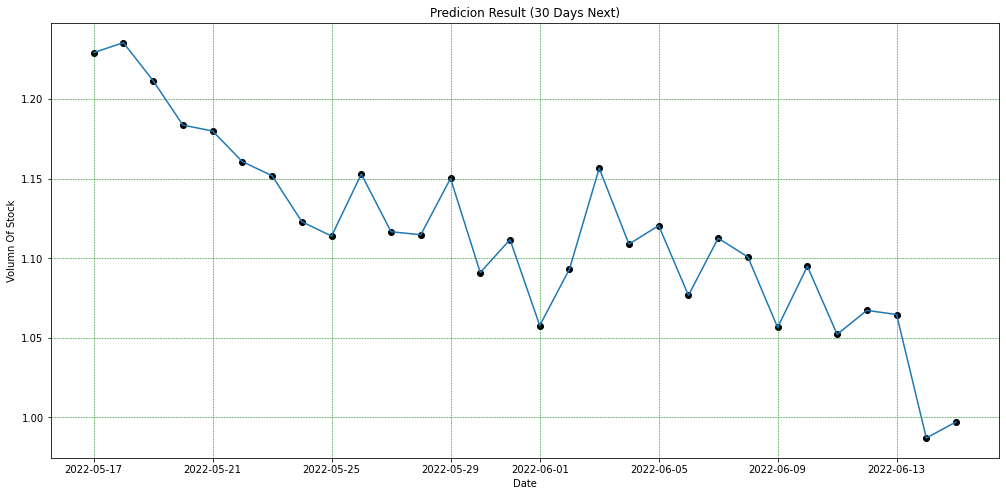

In [ ]:
x = df.index
y = df["Predicted Values"]

plt.xlabel("Date")
plt.ylabel("Volumn Of Stock")

plt.plot(x, y)
plt.scatter(x, y, color='black')

plt.title("Predicion Result (30 Days Next)")
plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)


plt.show()

# Dump The model

In [ ]:
from joblib import dump, load
# dump(model, 'LSTM.joblib') 

INFO:tensorflow:Assets written to: ram://ad0c6da1-23e7-4710-a51c-ecf8480aaee2/assets


INFO:tensorflow:Assets written to: ram://ad0c6da1-23e7-4710-a51c-ecf8480aaee2/assets


['LSTM.joblib']

In [ ]:
# clf = load('filename.joblib') 

In [ ]:
import tensorflow as tf

In [ ]:
# save model
model.save('LSTM_Model.h5')
print('Model Saved!')

Model Saved!
